# Introduction
This project aims to draw the connection between transportation crashes occurred in the city of San Francisco and the historical weather forecasts in the same area. I will do so by examining the temperature, windspeed, humidity, weather condition, and road surface condition against the collision severity and fatalities. There is also the possibility that the vehicle type may be relevant. 

The expectation is that inclement weather such as heavy rain or snow may lead to higher traffic accidents in certain areas of the city. 

# 1. Data Preprocessing and Wrangling
## 1.1. Import libraries

In [48]:
import requests
import json
import pandas as pd
from datetime import datetime   
import time
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import dates as dates
import seaborn as sns
import geopandas as gpd
import zipfile

# Format and style
%matplotlib inline


## 1.2. Dataset 1


This dataset contains all crashes resulting in an injury in the City of San Francisco. Fatality year-to-date crash data is obtained from the Office of the Chief Medical Examiner (OME) death records, and only includes those cases that meet the San Francisco Vision Zero Fatality Protocol maintained by the San Francisco Department of Public Health (SFDPH), San Francisco Police Department (SFPD), and San Francisco Municipal Transportation Agency (SFMTA). Injury crash data is obtained from SFPD’s Interim Collision System for 2018 through the current year-to-date, Crossroads Software Traffic Collision Database (CR) for years 2013-2017 and the Statewide Integrated Transportation Record System (SWITRS) maintained by the California Highway Patrol for all years prior to 2013. Only crashes with valid geographic information are mapped. All geocodable crash data is represented on the simplified San Francisco street centerline model maintained by the Department of Public Works (SFDPW). Collision injury data is queried and aggregated on a quarterly basis. Crashes occurring at complex intersections with multiple roadways are mapped onto a single point and injury and fatality crashes occurring on highways are excluded.



Additional information: https://data.sfgov.org/Public-Safety/Traffic-Crashes-Resulting-in-Injury/ubvf-ztfx

In [ ]:
Collision_API1 = "https://data.sfgov.org/resource/ubvf-ztfx.json"
resp1 = requests.get(Collision_API1)

# We transform the returned JSON answer from the API into a Python dictionary object
results = json.loads(resp1.text)

#create dataframe from list of dictionary
df = pd.DataFrame(results)

#View available columns
df.columns

Index(['id', 'unique_id', 'cnn_intrsctn_fkey', 'case_id_pkey', 'tb_latitude',
       'tb_longitude', 'geocode_source', 'geocode_location',
       'collision_datetime', 'collision_date', 'collision_time',
       'accident_year', 'month', 'day_of_week', 'time_cat', 'juris',
       'officer_id', 'reporting_district', 'beat_number', 'primary_rd',
       'secondary_rd', 'distance', 'direction', 'weather_1', 'weather_2',
       'collision_severity', 'type_of_collision', 'mviw', 'ped_action',
       'road_surface', 'road_cond_1', 'road_cond_2', 'lighting',
       'control_device', 'intersection', 'vz_pcf_code', 'vz_pcf_group',
       'vz_pcf_description', 'vz_pcf_link', 'number_killed', 'number_injured',
       'street_view', 'dph_col_grp', 'dph_col_grp_description', 'party1_type',
       'party1_dir_of_travel', 'party1_move_pre_acc', 'party2_type',
       'party2_dir_of_travel', 'party2_move_pre_acc', 'point',
       'data_loaded_at', ':@computed_region_jwn9_ihcz',
       ':@computed_region_

In [ ]:
#identify collumns with too much null values
missing_percentages = df.isna().sum().sort_values(ascending = False)/len(df)
col_name = missing_percentages[missing_percentages != 0].index
a = list(col_name)
a.remove('tb_longitude')
a.remove('tb_latitude')

In [ ]:
#remove collumns with too much null values
df = df.drop(a,axis=1)

In [ ]:
#drop rows with null values in location and time columns
df = df.dropna(subset=['tb_longitude','tb_latitude'])

In [ ]:
# create new column with total number of people involved
df['number_killed'] = df['number_killed'].astype('int')
df['number_injured'] = df['number_injured'].astype('int')
df['total_involved'] = df['number_killed']+df['number_injured']
df['total_involved'] = df['total_involved'].astype('int')
df.head(10)

,id,unique_id,cnn_intrsctn_fkey,case_id_pkey,tb_latitude,tb_longitude,geocode_source,geocode_location,collision_datetime,collision_date,...,vz_pcf_description,number_killed,number_injured,dph_col_grp,dph_col_grp_description,party1_type,party1_dir_of_travel,party1_move_pre_acc,data_loaded_at,total_involved
0,vw_geo_sfpd_cr_switrs_all_types_col_cty_union....,15995,23908000.0,130316559,37.7790321327699,-122.401843272924,SFPD-CROSSROADS,CITY STREET,2013-04-18T06:15:00.000,2013-04-18T00:00:00.000,...,Unknown,0,2,AA,Vehicle(s) Only Involved,Driver,Not Stated,Not Stated,2023-01-28T03:30:22.818,2
1,vw_geo_sfpd_cr_switrs_all_types_col_cty_union....,16469,23944000.0,140665164,37.7814995083039,-122.404933346348,SFPD-CROSSROADS,CITY STREET,2014-08-09T22:48:00.000,2014-08-09T00:00:00.000,...,Unsafe speed for prevailing conditions,0,1,AA,Vehicle(s) Only Involved,Driver,East,Proceeding Straight,2023-01-28T03:30:22.857,1
2,vw_geo_sfpd_cr_switrs_all_types_col_cty_union....,10088,24055000.0,160880063,37.7654476084469,-122.413105242334,SFPD-CROSSROADS,CITY STREET,2016-10-29T01:37:00.000,2016-10-29T00:00:00.000,...,Unsafe speed for prevailing conditions,0,1,AA,Vehicle(s) Only Involved,Driver,West,Ran Off Road,2023-01-28T03:30:23.297,1
3,vw_geo_sfpd_cr_switrs_all_types_col_cty_union....,27168,30734000.0,140065570,37.7892643223925,-122.40137549141,SFPD-CROSSROADS,CITY STREET,2014-01-23T02:00:00.000,2014-01-23T00:00:00.000,...,Following too closely prohibited,0,1,CC,Vehicle-Bicycle,Driver,West,Proceeding Straight,2023-01-28T03:30:23.471,1
4,vw_geo_sfpd_cr_switrs_all_types_col_cty_union....,5037,22132000.0,4318561,37.7307329067636,-122.43973734583,SFPD-CROSSROADS,CITY STREET,2009-07-08T16:26:00.000,2009-07-08T00:00:00.000,...,Failure to stop at STOP sign,0,1,CC,Vehicle-Bicycle,Driver,Not Stated,Making Right Turn,2023-01-28T03:30:23.522,1
5,vw_geo_sfpd_cr_switrs_all_types_col_cty_union....,40135,27336000.0,4318607,37.7542121464069,-122.477106597196,SFPD-CROSSROADS,CITY STREET,2009-07-19T15:12:00.000,2009-07-19T00:00:00.000,...,Unsafe speed for prevailing conditions,0,1,AA,Vehicle(s) Only Involved,Driver,East,Ran Off Road,2023-01-28T03:30:23.662,1
6,vw_geo_sfpd_cr_switrs_all_types_col_cty_union....,32191,25301999.999999996,140202584,37.7922214882359,-122.421020117942,SFPD-CROSSROADS,CITY STREET,2014-03-09T17:07:00.000,2014-03-09T00:00:00.000,...,Unsafe starting or backing on highway,0,1,CC,Vehicle-Bicycle,Driver,South,Entering Traffic,2023-01-28T03:30:24.024,1
7,vw_geo_sfpd_cr_switrs_all_types_col_cty_union....,7607,21901000.0,140897464,37.747785879517,-122.425520701618,SFPD-CROSSROADS,CITY STREET,2014-10-23T11:45:00.000,2014-10-23T00:00:00.000,...,Opening door on traffic side when unsafe,0,1,EE,Bicycle-Parked Car,Parked Vehicle,Not Stated,Parked,2023-01-28T03:30:26.149,1
8,vw_geo_sfpd_cr_switrs_all_types_col_cty_union....,9542,23778000.0,140908873,37.7646643174987,-122.404496977122,SFPD-CROSSROADS,CITY STREET,2014-10-27T09:20:00.000,2014-10-27T00:00:00.000,...,Failure to stop at STOP sign,0,1,AA,Vehicle(s) Only Involved,Driver,North,Proceeding Straight,2023-01-28T03:30:26.186,1
9,vw_geo_sfpd_cr_switrs_all_types_col_cty_union....,17396,54188000.0,140941538,37.7672341937665,-122.422111255375,SFPD-CROSSROADS,CITY STREET,2014-11-06T18:55:00.000,2014-11-06T00:00:00.000,...,Unsafe speed for prevailing conditions,0,1,CC,Vehicle-Bicycle,Bicyclist,South,Passing Other Vehicle,2023-01-28T03:30:26.291,1


In [ ]:
#Save sample json file as checkpoint
df.to_json('Collision.json',orient='records')
#get crash data/checkpoint
crash = json.load(open('Collision.json','r'))

In order to translate the data into a readable format, it was loaded, into Pandas Data Frames. Upon closer inspection, many of the features from the original dataset 1 have missing data, but luckily many of them were not relevant to the analysis so they were removed promptly. There were cases with missing data in the longitude and latitude features (7%) so these were also removed as we need the data to collect the weather data. An aggregated feature was created afterwards to sum the total the number of casualty and injured in each incident.

## 1.3. Dataset 2

Historical weather data provided by OpenWeather allow access to hourly weather data at specific points in time. The dataset will be extracted based on latitude and longitude provided from the crash site dataset 

The documentation for this data is https://openweathermap.org/api/one-call-3#history

In [ ]:
#Create function to convert time to UNIX timestamp format
def convert_unix(i):
    datetime_obj = datetime.strptime(i,
                                 "%Y-%m-%dT%H:%M:%S.000")
    unix_time = datetime.timestamp(datetime_obj)
    return unix_time

#insert converted data into json file
 
for i in crash:
    bi = int(convert_unix(i['collision_datetime']))
    unix_add = {"unix_dict": bi} 
    i.update(unix_add)


In [ ]:
query_template = '''https://api.openweathermap.org/data/3.0/onecall/timemachine?lat=%s&lon=%s&dt=%s&appid=%s''' 
API = []
for entry in crash: 
    lat = entry['tb_latitude'] 
    lon = entry['tb_longitude']
    dt = entry['unix_dict'] 
    appid = "503ed749861a1697a1d7ac5455250b08" 
    query_parameters = (lat, lon, dt, appid) 
    Weather_API = query_template % query_parameters 
    API.append(Weather_API)


In [ ]:
#request data
weather_json = []

for link in API:
    weather_data = requests.get(link).json()
    ver1 = weather_data['data'][0]
    ver1.update(weather_data)
    ver1.pop('data')
    ver2 = ver1['weather'][0]
    ver2.update(ver1)
    ver2.pop('weather')
    weather_json.append(ver2)
    time.sleep(1)

In [ ]:
#convert to dataframe
results_df = pd.DataFrame(weather_json)
results_df.head(10)

,id,main,description,icon,dt,sunrise,sunset,temp,feels_like,pressure,...,dew_point,clouds,wind_speed,wind_deg,wind_gust,lat,lon,timezone,timezone_offset,rain
0,800,Clear,clear sky,01n,1366280100,1366291771,1366339664,284.18,283.27,1023,...,279.73,0,1.03,270,1.03,37.7790,-122.4018,America/Los_Angeles,-25200,NaN
1,802,Clouds,scattered clouds,03d,1407638880,1407590407,1407640209,290.30,290.39,1014,...,288.47,30,5.88,277,NaN,37.7815,-122.4049,America/Los_Angeles,-25200,NaN
2,802,Clouds,scattered clouds,03n,1477719420,1477665085,1477703710,290.21,290.50,1014,...,289.73,25,1.32,180,NaN,37.7654,-122.4131,America/Los_Angeles,-25200,NaN
3,800,Clear,clear sky,01n,1390460400,1390404033,1390440097,283.11,282.71,1013,...,281.87,0,1.54,225,1.54,37.7893,-122.4014,America/Los_Angeles,-28800,NaN
4,800,Clear,clear sky,01d,1247084760,1247057729,1247110434,292.64,292.52,1015,...,287.46,1,6.01,297,NaN,37.7307,-122.4397,America/Los_Angeles,-25200,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
988,804,Clouds,overcast clouds,04n,1456410240,1456411643,1456451913,283.27,282.90,1020,...,282.97,100,0.78,92,NaN,37.7829,-122.4208,America/Los_Angeles,-28800,NaN
989,803,Clouds,broken clouds,04d,1404326160,1404305520,1404358510,290.11,290.13,1012,...,287.93,60,3.10,273,NaN,37.7292,-122.4152,America/Los_Angeles,-25200,NaN
990,804,Clouds,overcast clouds,04n,1437622980,1437570289,1437622025,289.68,289.74,1011,...,288.03,94,5.38,267,NaN,37.7584,-122.4213,America/Los_Angeles,-25200,NaN
991,804,Clouds,overcast clouds,04d,1457973900,1457965286,1458008171,286.13,285.29,1023,...,280.58,98,2.42,318,NaN,37.7710,-122.4369,America/Los_Angeles,-25200,NaN


In [ ]:
#Save sample json file
results_df.to_json('Collision_weather.json',orient='records')

In [ ]:
#get crash data/checkpoint
weather = json.load(open('Collision_weather.json','r'))

## 1.4. Merge two datasets


In [ ]:
merge_df = pd.merge(pd.DataFrame(crash), results_df, left_on='unix_dict', right_on='dt')
#save new dataframe as csv file
merge_df.to_csv('Collision_weather_merged.csv')

NameError: name 'results_df' is not defined

I used the location and time data to with the OpenWeather API to collect weather data at the time reported at each incident. Weather data was also joined with the collision data based on these features. 

## 1.5. Clean Merged Data

More unncessary features are removed to consolidate the dataset for analysis and give room for dummy variables created for categorical variables like road surface condition, collision severity, etc.


In [50]:
merged = pd.read_csv("Collision_weather_merged.csv")

In [51]:
#remove unnecessary columns
remov = ['Unnamed: 0', 'id_x', 'unique_id', 'cnn_intrsctn_fkey', 'case_id_pkey',
             'geocode_source', 'geocode_location','juris','direction', 'type_of_collision', 
             'mviw', 'ped_action','control_device', 'intersection', 'vz_pcf_description',
             'dph_col_grp', 'dph_col_grp_description', 'party1_dir_of_travel',
             'party1_move_pre_acc','data_loaded_at', 'unix_dict', 'id_y', 'icon', 'dt', 'sunrise',
             'sunset','feels_like','lat', 'lon', 'timezone', 'timezone_offset', 'rain','wind_gust','road_cond_2']
merged = merged.drop(remov,axis=1)

In [52]:
#convert to correct datatypes

#time
merged["collision_datetime"] = pd.to_datetime(merged["collision_datetime"], format="%Y-%m-%dT%H:%M:%S")
merged["collision_date"] = pd.to_datetime(merged["collision_date"], format="%Y-%m-%d")
merged["Hour"] = (merged["collision_datetime"].dt.time)

#categoricals
merged["description"] =  pd.Categorical(merged["description"], ordered=False)
merged["collision_severity"] =  pd.Categorical(merged["collision_severity"], categories = ['Injury (Other Visible)','Injury (Complaint of Pain)','Injury (Severe)','Fatal'], ordered=True)

#accident count
merged['Accident_Count']=1

# convert temperature from kelvin to fahrenheit
Fahr1 = []
for K in merged["temp"]:
    F = 1.8*(K-273) + 32
    Fahr1.append(F)
merged['temp'] = Fahr1

Fahr2 = []
for K in merged["dew_point"]:
    F = 1.8*(K-273) + 32
    Fahr2.append(F)
merged['dew_point'] = Fahr2

In [53]:
# Combine same values
merged['road_surface'] = merged['road_surface'].replace(['Slippery'], 'Wet')
merged['road_surface'].value_counts()

Dry           855
Wet           109
Not Stated     31
Name: road_surface, dtype: int64

In [143]:
# Create dummy variables
dummies = pd.get_dummies(merged[['collision_severity','main','road_surface','party1_type','lighting']])


In [144]:
log_dat = pd.concat([merged, dummies],axis=1)

#Reset index
log_dat.reset_index(inplace=True)
log_dat.drop('index',axis=1,inplace=True)


# 2. Exploratory Data Analysis (EDA) and Visualizations
## 2.1. Overview and Summary Statistics

Overall, we have records of 994 collisions recorded from 2005 to 2022. The consists of two tables which were merged into one and include the following features:

* geographic variables: 'tb_latitude', 'tb_longitude', 'primary_rd'
* time variables: 'collision_datetime', 'collision_date',       'accident_year', 'month', 'day_of_week', 'Hour'
* weather variables: 'weather_1', 'main', 'description', 'temp', 'pressure', 'humidity', 'dew_point','clouds', 'wind_speed', 'wind_deg'
* collision details:'collision_severity', 'road_surface', 'road_cond_1', 'lighting','number_killed', 'number_injured', 'party1_type', 'total_involved'

Data dictionary: [link]

The victims involved range around 1 to 2 people with outlier of 6 for one incident. The weather condition when the collisions occured were mostly very humid and has high atmospheric temperature below which water droplets begin to condense and dew can form. There was mostly a West-ward (260-280 degree) gentle breeze (8 - 12 mph ; 3.5-5 m/s). The temperature was normally distributed with average of around 60 Fahrenheit. We can conclude that the collisions happened mostly during cool and humid weather. Understandably, SF weather tends to be cool and humid because of its geographical location.

In [ ]:
print("The data set has {} collision cases and a total of {} variable".format(list(merged.shape)[0]-1,list(merged.shape)[1]))
print("The column names are {}".format(list(merged.columns)))

#Summary statistics of relevant quantitative variables
quant = merged[['number_killed','number_injured','total_involved','temp',
       'pressure', 'humidity', 'dew_point', 'clouds', 'wind_speed', 'wind_deg']]
round(quant.describe(),2)

The data set has 994 collision cases and a total of 28 variable
The column names are ['tb_latitude', 'tb_longitude', 'collision_datetime', 'collision_date', 'accident_year', 'month', 'day_of_week', 'primary_rd', 'weather_1', 'collision_severity', 'road_surface', 'road_cond_1', 'lighting', 'number_killed', 'number_injured', 'party1_type', 'total_involved', 'main', 'description', 'temp', 'pressure', 'humidity', 'dew_point', 'clouds', 'wind_speed', 'wind_deg', 'Hour', 'Accident_Count']


,number_killed,number_injured,total_involved,temp,pressure,humidity,dew_point,clouds,wind_speed,wind_deg
count,995.00,995.00,995.00,995.00,995.00,995.00,995.00,995.00,995.00,995.00
mean,0.01,1.23,1.24,59.95,1016.24,79.21,52.88,49.49,3.55,235.40
std,0.09,0.62,0.62,8.34,4.91,14.54,7.97,39.48,1.93,83.38
min,0.00,0.00,1.00,36.61,978.00,10.00,9.81,0.00,0.11,0.00
25%,0.00,1.00,1.00,54.27,1013.00,72.00,48.38,5.00,2.10,193.50
50%,0.00,1.00,1.00,59.50,1016.00,82.00,54.27,51.00,3.28,267.00
75%,0.00,1.00,1.00,65.08,1019.00,90.00,58.46,93.00,4.65,293.00
max,1.00,6.00,6.00,89.83,1034.00,99.00,67.98,100.00,12.34,360.00


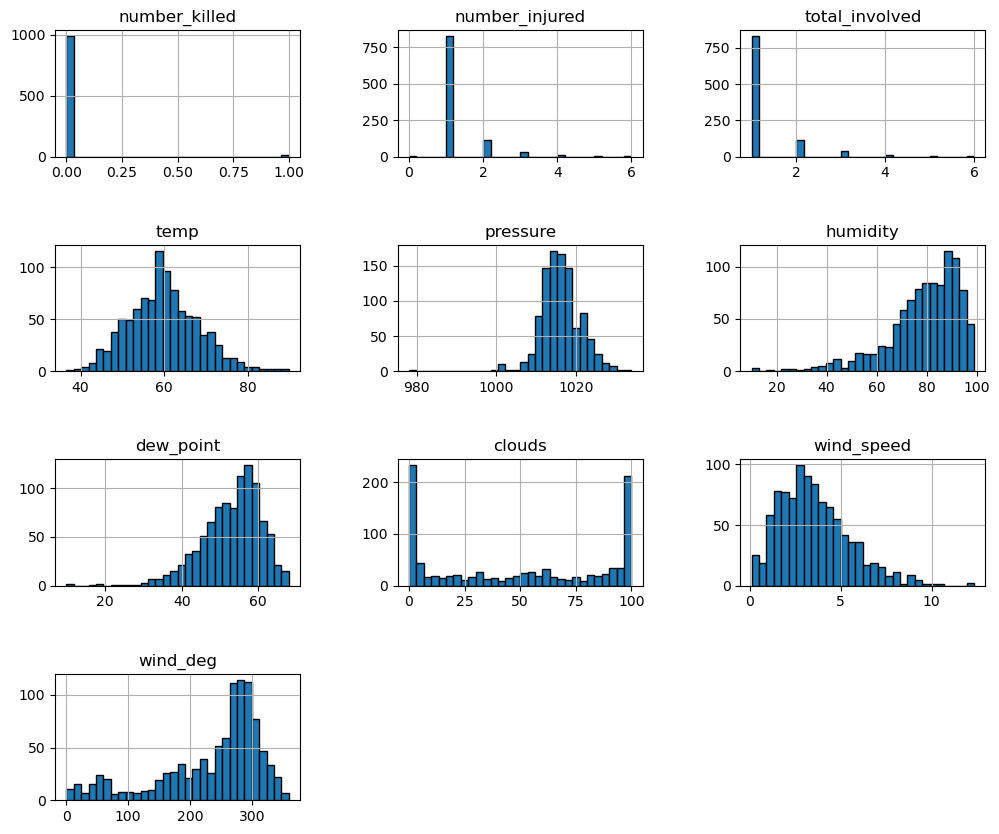

In [ ]:
#histogram distribution of quantitative variables
quant.hist(figsize=(12, 10), bins=30, edgecolor="black")
plt.subplots_adjust(hspace=0.7, wspace=0.4)

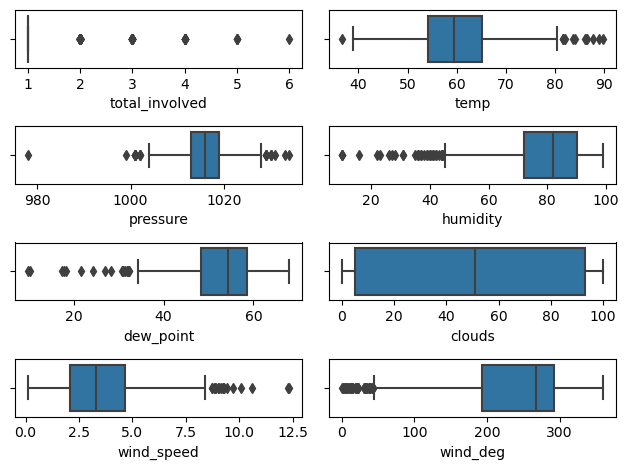

In [ ]:
# Boxplots for some of the features

features_for_boxplot = ['total_involved','temp','pressure', 'humidity', 'dew_point', 'clouds', 'wind_speed', 'wind_deg']


# Creating subplot axes
fig, axes = plt.subplots(4,2)


# Iterating through axes and names
for name, ax in zip(features_for_boxplot, axes.flatten()):
    sns.boxplot(x=merged[name], ax=ax)
    plt.tight_layout()

### Categorical Variables

As seen before, the majority of collisions are moderate and happened during mostly during cool, cloudy, and very humid weather. One additional insight is that the incidents happened more to drivers, which could indicate poor road condition and visibility.

Text(0.5, 1.0, 'Number of Accidents\nby Road Surface Conditions')

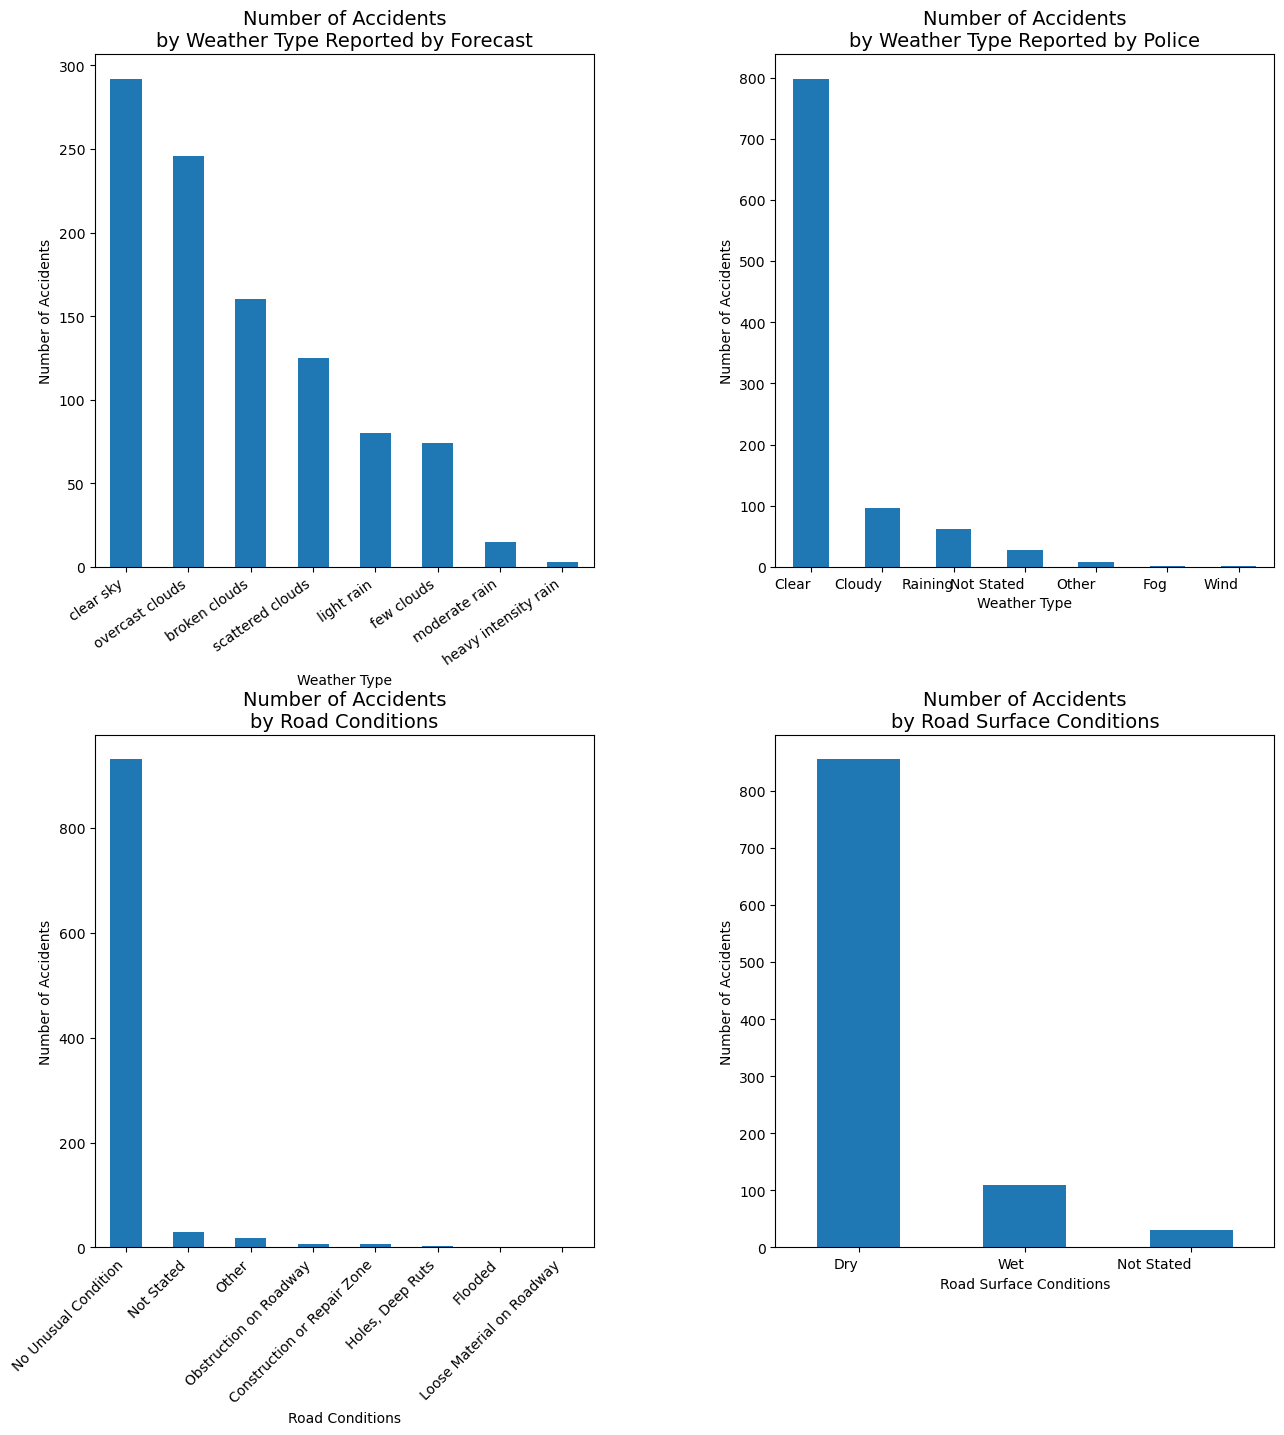

In [170]:
#Plot summary of accident counts 3
fig,ax = plt.subplots(2,2,figsize=(15,15))
fig.tight_layout(pad=10.0)

#Weather
merged["description"].value_counts().plot(kind = 'bar', ax=ax[0,0])
plt.setp(ax[0,0].get_xticklabels(), rotation=35, ha='right')
ax[0,0].set_ylabel('Number of Accidents')
ax[0,0].set_xlabel('Weather Type')
ax[0,0].set_title('Number of Accidents\nby Weather Type Reported by Forecast',fontsize=14)

#Weather 2
merged["weather_1"].value_counts().plot(kind = 'bar', ax=ax[0,1])
plt.setp(ax[0,1].get_xticklabels(), rotation=360, ha='right')
ax[0,1].set_ylabel('Number of Accidents')
ax[0,1].set_xlabel('Weather Type')
ax[0,1].set_title('Number of Accidents\nby Weather Type Reported by Police',fontsize=14)

#Road Conditions
merged["road_cond_1"].value_counts().plot(kind = 'bar', ax=ax[1,0])
plt.setp(ax[1,0].get_xticklabels(), rotation=45, ha='right')
ax[1,0].set_ylabel('Number of Accidents')
ax[1,0].set_xlabel('Road Conditions')
ax[1,0].set_title('Number of Accidents\nby Road Conditions',fontsize=14)


#Road Surface
merged["road_surface"].value_counts().plot(kind = 'bar', ax=ax[1,1])
plt.setp(ax[1,1].get_xticklabels(), rotation=360, ha='right')
ax[1,1].set_ylabel('Number of Accidents')
ax[1,1].set_xlabel('Road Surface Conditions')
ax[1,1].set_title('Number of Accidents\nby Road Surface Conditions',fontsize=14)

Text(0.5, 1.0, 'Number of Accidents\nby Top 5 Roads Occurred')

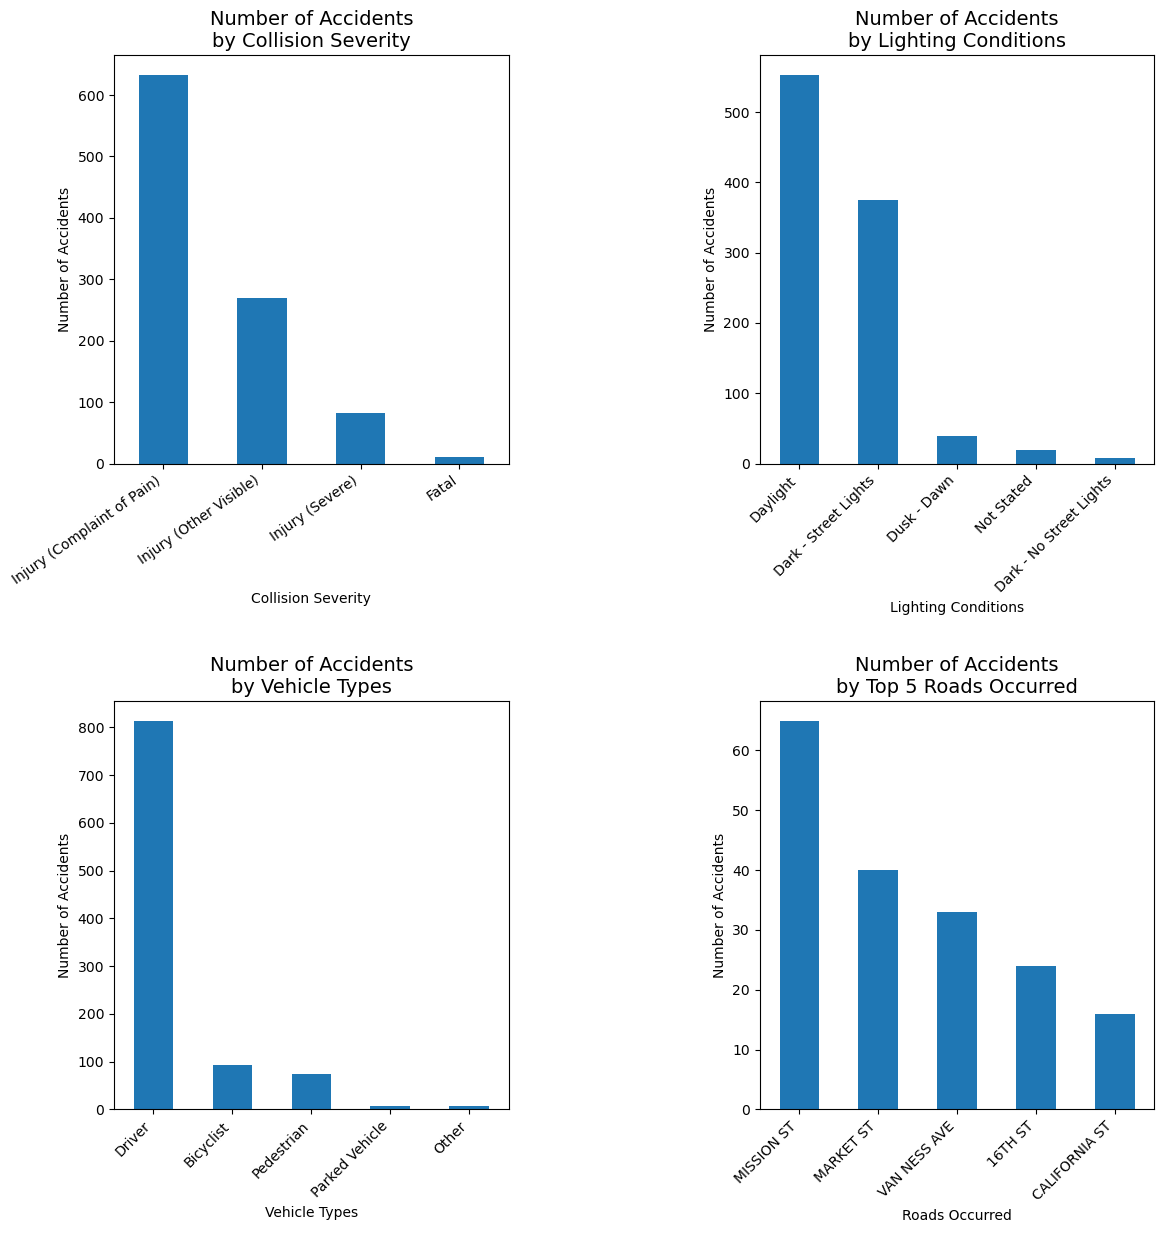

In [ ]:
#Plot summary of accident counts 2
fig,ax = plt.subplots(2,2,figsize=(15,15))
fig.tight_layout(pad=15.0)

#Collision Severity
merged["collision_severity"].value_counts().plot(kind = 'bar', ax=ax[0,0])
plt.setp(ax[0,0].get_xticklabels(), rotation=35, ha='right')
ax[0,0].set_ylabel('Number of Accidents')
ax[0,0].set_xlabel('Collision Severity')
ax[0,0].set_title('Number of Accidents\nby Collision Severity',fontsize=14)

#lighting
merged["lighting"].value_counts().plot(kind = 'bar', ax=ax[0,1])
plt.setp(ax[0,1].get_xticklabels(), rotation=45, ha='right')
ax[0,1].set_ylabel('Number of Accidents')
ax[0,1].set_xlabel('Lighting Conditions')
ax[0,1].set_title('Number of Accidents\nby Lighting Conditions',fontsize=14)

#Party 1 vehicle type
merged["party1_type"].value_counts().plot(kind = 'bar', ax=ax[1,0])
plt.setp(ax[1,0].get_xticklabels(), rotation=45, ha='right')
ax[1,0].set_ylabel('Number of Accidents')
ax[1,0].set_xlabel('Vehicle Types')
ax[1,0].set_title('Number of Accidents\nby Vehicle Types',fontsize=14)


#The road the crash occurred on
merged["primary_rd"].value_counts().nlargest(5).plot(kind = 'bar', ax=ax[1,1])
plt.setp(ax[1,1].get_xticklabels(), rotation=45, ha='right')
ax[1,1].set_ylabel('Number of Accidents')
ax[1,1].set_xlabel('Roads Occurred')
ax[1,1].set_title('Number of Accidents\nby Top 5 Roads Occurred',fontsize=14)

Text(0.5, 1.0, 'Number of Accidents\nby Top 10 Hour of Day')

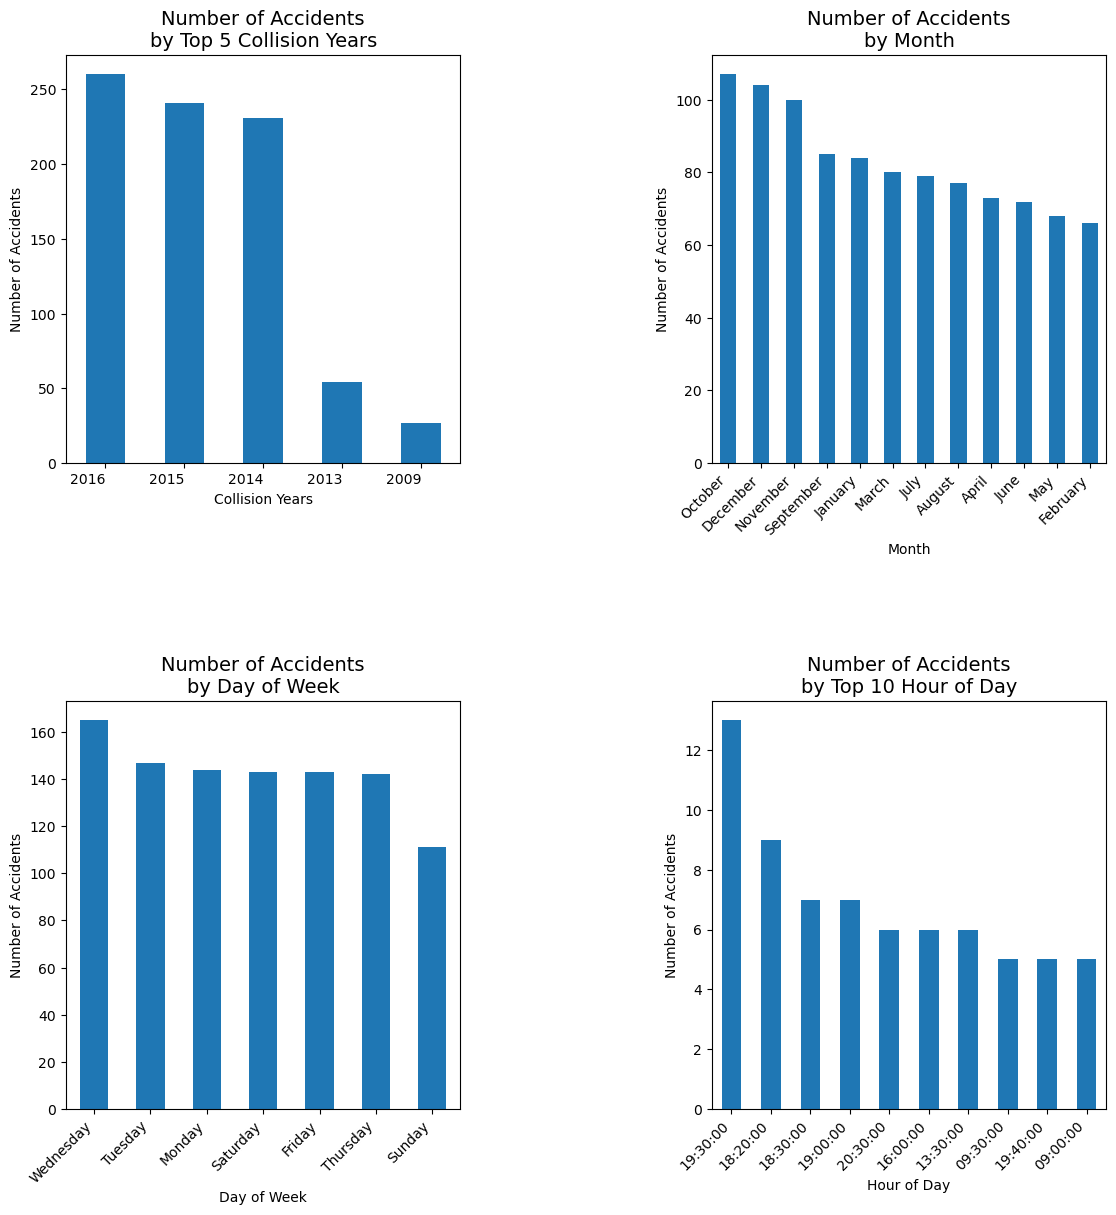

In [ ]:
#Plot summary of accident counts 3
fig,ax = plt.subplots(2,2,figsize=(15,15))
fig.tight_layout(pad=15.0)

#Year when the crash occurred
merged["accident_year"].value_counts().nlargest(5).plot(kind = 'bar', ax=ax[0,0])
plt.setp(ax[0,0].get_xticklabels(), rotation=360, ha='right')
ax[0,0].set_ylabel('Number of Accidents')
ax[0,0].set_xlabel('Collision Years')
ax[0,0].set_title('Number of Accidents\nby Top 5 Collision Years',fontsize=14)

#Month when the crash occurred
merged["month"].value_counts().plot(kind = 'bar', ax=ax[0,1])
plt.setp(ax[0,1].get_xticklabels(), rotation=45, ha='right')
ax[0,1].set_ylabel('Number of Accidents')
ax[0,1].set_xlabel('Month')
ax[0,1].set_title('Number of Accidents\nby Month',fontsize=14)

#Day of week when the crash occurred
merged["day_of_week"].value_counts().plot(kind = 'bar', ax=ax[1,0])
plt.setp(ax[1,0].get_xticklabels(), rotation=45, ha='right')
ax[1,0].set_ylabel('Number of Accidents')
ax[1,0].set_xlabel('Day of Week')
ax[1,0].set_title('Number of Accidents\nby Day of Week',fontsize=14)


#Hour when the crash occurred
merged["Hour"].value_counts().nlargest(10).plot(kind = 'bar', ax=ax[1,1])
plt.setp(ax[1,1].get_xticklabels(), rotation=45, ha='right')
ax[1,1].set_ylabel('Number of Accidents')
ax[1,1].set_xlabel('Hour of Day')
ax[1,1].set_title('Number of Accidents\nby Top 10 Hour of Day',fontsize=14)

## 2.3. Correlation and feature selection

Based on the map below, we can see that the majority of the crashes over the year occur in the Downtown, Chinatown and Mission District. The collision severity in these areas appear to be mostly light to moderate injuries.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


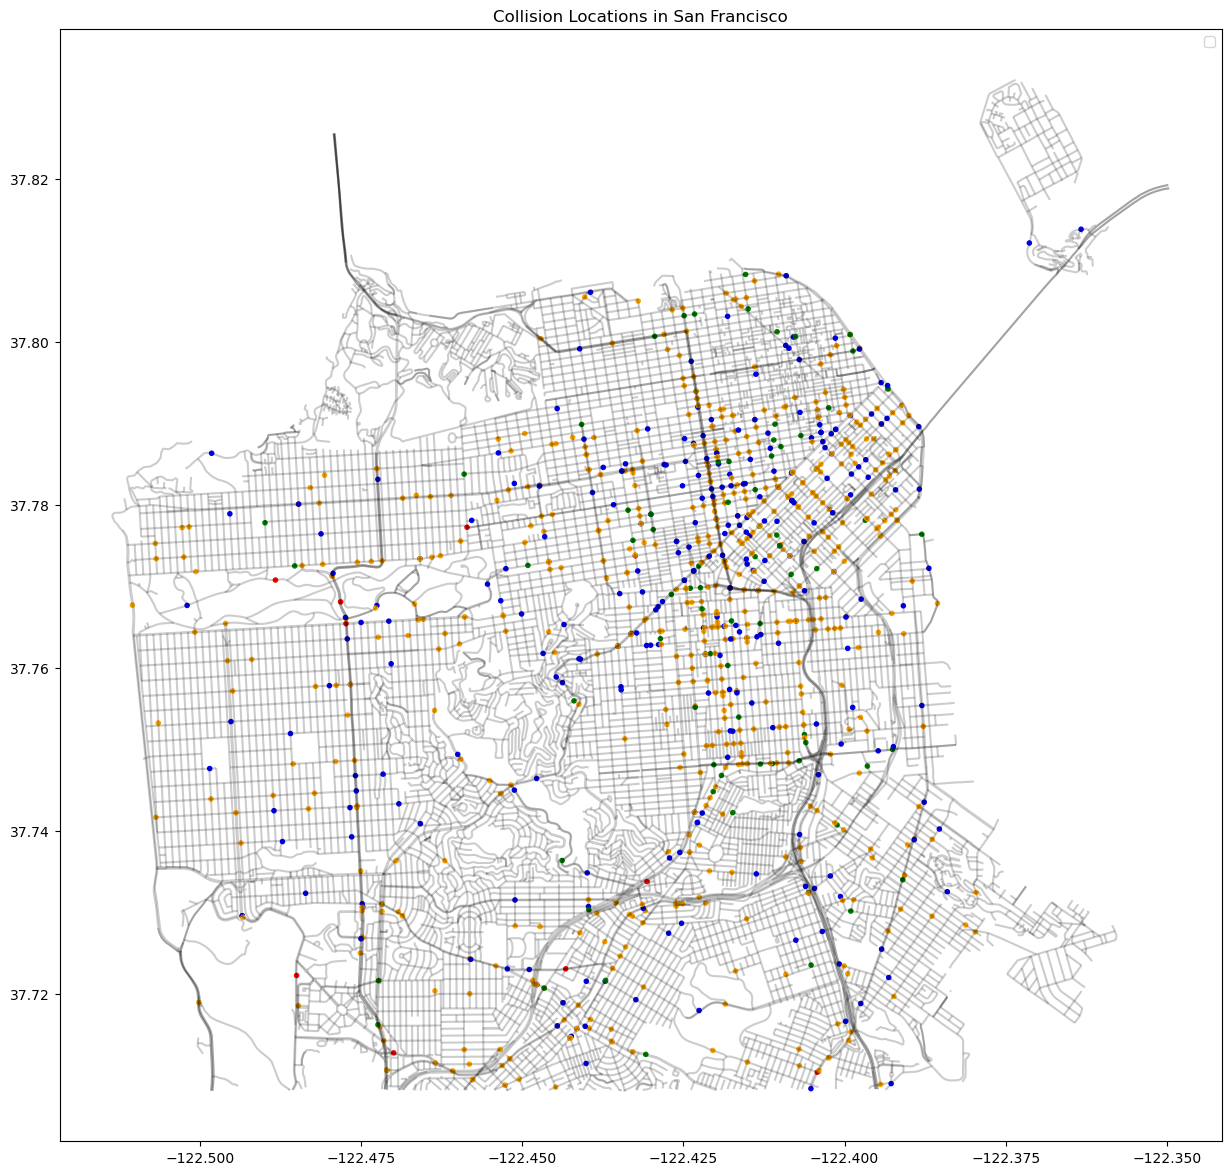

In [121]:
with zipfile.ZipFile('tl_2017_06075_roads.zip', 'r') as zip_ref:
    zip_ref.extractall('shapefiles')
# Import shapefile as GeoDataFrame
geo_df = gpd.read_file('shapefiles/tl_2017_06075_roads.shp')
df_sf = merged[['collision_severity', 'tb_latitude', 'tb_longitude']]

# Initialize our plot
fig, ax = plt.subplots(figsize=(15,15))
# Plot our SF GeoDataFrame
geo_df.plot(ax=ax, alpha = .2,color = 'black')

colors = {'Injury (Complaint of Pain)':'orange', 'Injury (Severe)':'green' , 'Injury (Other Visible)':'blue','Fatal':'red'}
labels = ['Injury (Complaint of Pain)', 'Injury (Severe)' , 'Injury (Other Visible)','Fatal']
 
# depict illustration
plot = plt.scatter(merged['tb_longitude'], merged['tb_latitude'], c=merged['collision_severity'].map(colors), marker = ".")
plt.title("Collision Locations in San Francisco")
ax.legend()
plt.show()

# Turn off axis
ax.set_axis_off()
fig.tight_layout()



The confusion matrix reveals that most collisions resulted in complaint of injury. There is some multicollinearity with temperature and dew point, clous and humidity, temperature and humidity. Unfortunately, there are no correlation between number of people involved with the quantitative variables, therefore a different approach is needed.

In [8]:
df_corr = merged[['total_involved','temp','pressure','humidity','dew_point','clouds','wind_speed','wind_deg']].corr()
round(df_corr,2)

,total_involved,temp,pressure,humidity,dew_point,clouds,wind_speed,wind_deg
total_involved,1.00,-0.00,0.00,0.01,0.01,-0.04,-0.01,-0.02
temp,-0.00,1.00,-0.27,-0.43,0.68,-0.20,0.15,0.25
pressure,0.00,-0.27,1.00,-0.06,-0.31,-0.07,-0.22,-0.16
humidity,0.01,-0.43,-0.06,1.00,0.34,0.41,-0.12,0.03
dew_point,0.01,0.68,-0.31,0.34,1.00,0.09,0.08,0.29
clouds,-0.04,-0.20,-0.07,0.41,0.09,1.00,-0.02,-0.14
wind_speed,-0.01,0.15,-0.22,-0.12,0.08,-0.02,1.00,0.18
wind_deg,-0.02,0.25,-0.16,0.03,0.29,-0.14,0.18,1.00


In [9]:
round(abs(df_corr[['total_involved']]).sort_values(by = 'total_involved', ascending = False),2)

,total_involved
total_involved,1.00
clouds,0.04
wind_deg,0.02
humidity,0.01
dew_point,0.01
wind_speed,0.01
temp,0.00
pressure,0.00


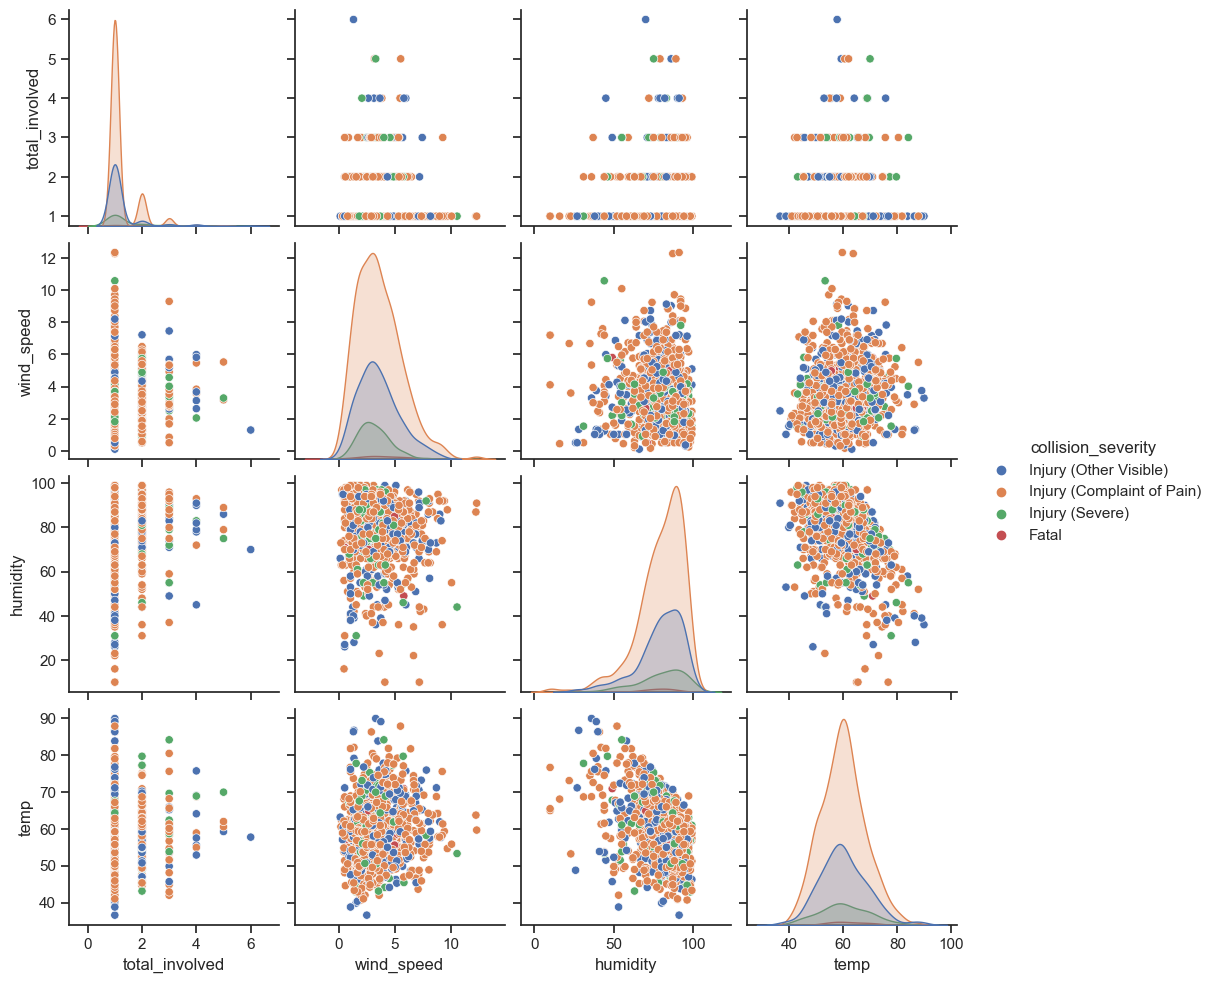

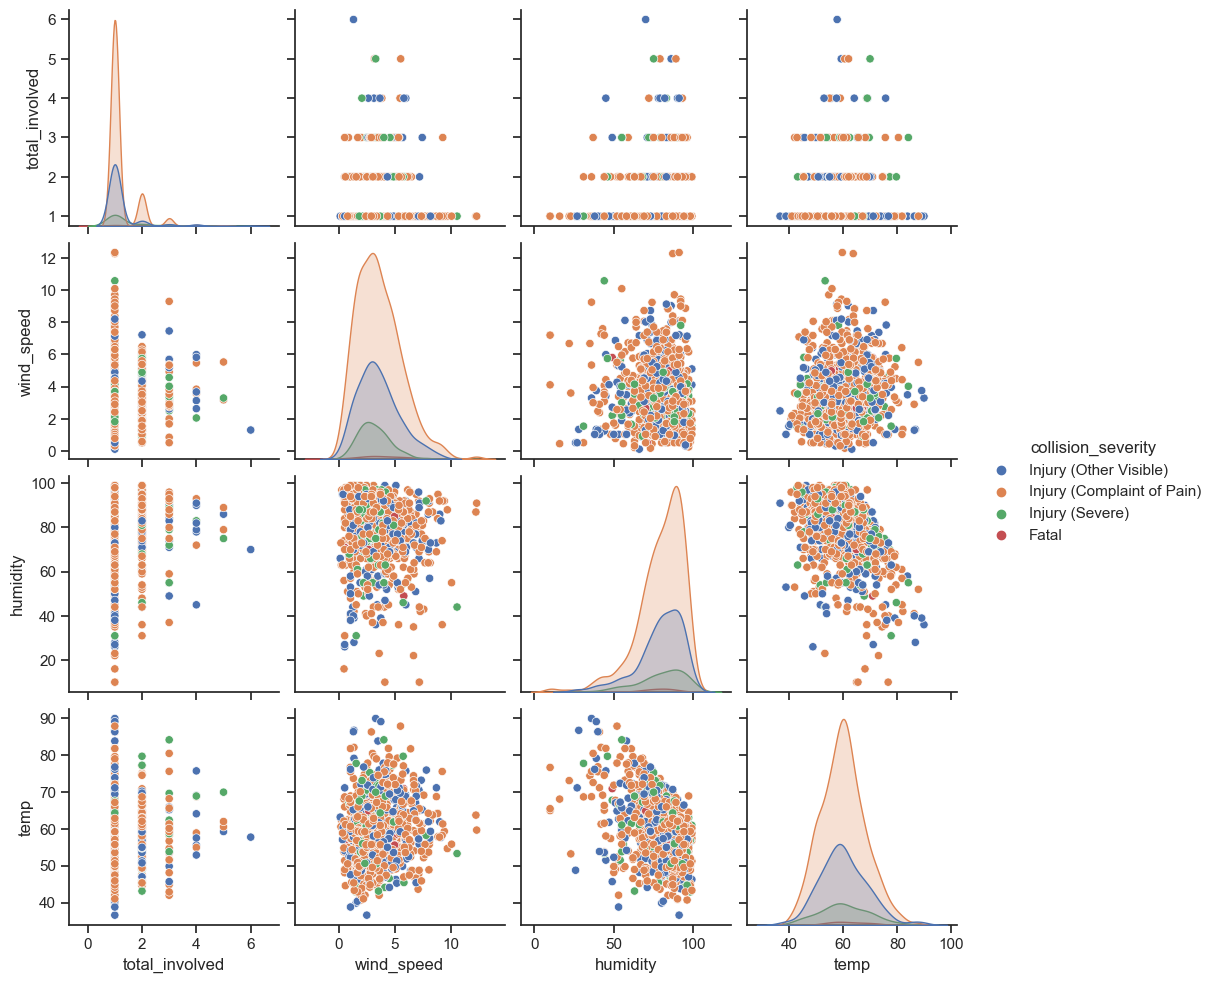

In [ ]:
sns.set_theme(style="ticks")

corr = merged[['total_involved','wind_speed','humidity','temp','collision_severity']]
sns.pairplot(corr, hue = 'collision_severity' )

plt.show()

The below graphs examine the relationship between collision severity, humidity, dew points, and some relevant categorical variables. While it is reported to be clear and cloudy for many of the accident, there is also the likelihood that high humidity and dew points can generate a lot of mist which cause low road visibility.

We see that among the categorical variables, collisions with moderate injuries are concentrated around values like clear/cloudy sky that we had previously seen with higher frequency during EDA. Month, week, and road conditions do not appear to show any meaningful relationship. The most interesting point is that there appear to be some correlations between the moderate injury collisions and higher dew points and humidity. However, this can be explained with skewed distribution of dew points and humidity and imbalanced proportion of moderate injury collisions. These would need to be taken into account during model selection and building. 

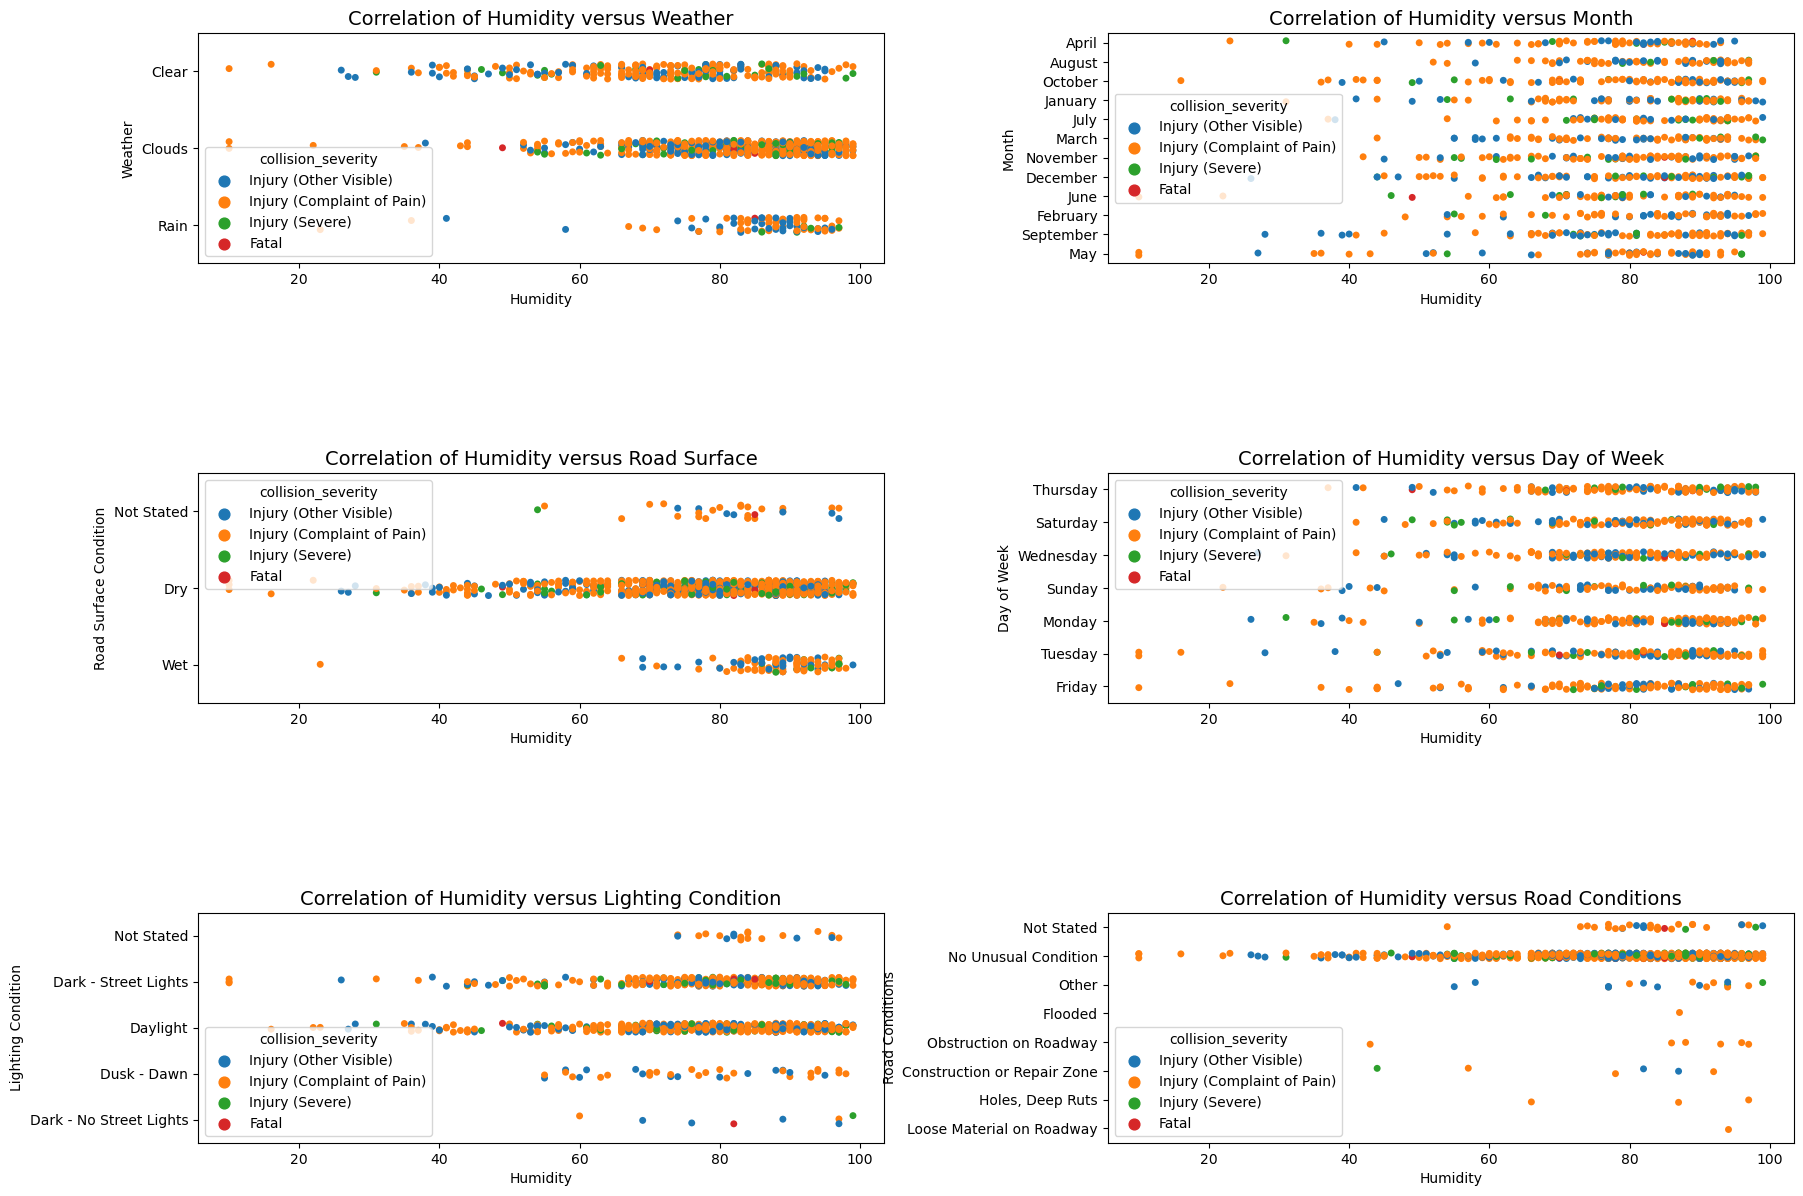

In [174]:
# Draw a categorical scatterplot to show each observation. stripplot is used to reduce overplotting
fig,ax = plt.subplots(3,2,figsize=(20,15))
fig.tight_layout(pad=13.0)

sns.stripplot(data=merged, x="humidity", y="main", hue="collision_severity",ax=ax[0,0])
ax[0,0].set_ylabel('Weather')
ax[0,0].set_xlabel('Humidity')
ax[0,0].set_title('Correlation of Humidity versus Weather',fontsize=14)

sns.stripplot(data=merged, x="humidity", y="road_surface", hue="collision_severity",ax=ax[1,0])
ax[1,0].set_ylabel('Road Surface Condition')
ax[1,0].set_xlabel('Humidity')
ax[1,0].set_title('Correlation of Humidity versus Road Surface',fontsize=14)

sns.stripplot(data=merged, x="humidity", y="lighting", hue="collision_severity",ax=ax[2,0])
ax[2,0].set_ylabel('Lighting Condition')
ax[2,0].set_xlabel('Humidity')
ax[2,0].set_title('Correlation of Humidity versus Lighting Condition',fontsize=14)

sns.stripplot(data=merged, x="humidity", y="month", hue="collision_severity", ax=ax[0,1])
ax[0,1].set_ylabel('Month')
ax[0,1].set_xlabel('Humidity')
ax[0,1].set_title('Correlation of Humidity versus Month',fontsize=14)

sns.stripplot(data=merged, x="humidity", y="day_of_week", hue="collision_severity",ax=ax[1,1])
ax[1,1].set_ylabel('Day of Week')
ax[1,1].set_xlabel('Humidity')
ax[1,1].set_title('Correlation of Humidity versus Day of Week',fontsize=14)

sns.stripplot(data=merged, x="humidity", y="road_cond_1", hue="collision_severity",ax=ax[2,1])
ax[2,1].set_ylabel('Road Conditions')
ax[2,1].set_xlabel('Humidity')
ax[2,1].set_title('Correlation of Humidity versus Road Conditions',fontsize=14)

plt.show()

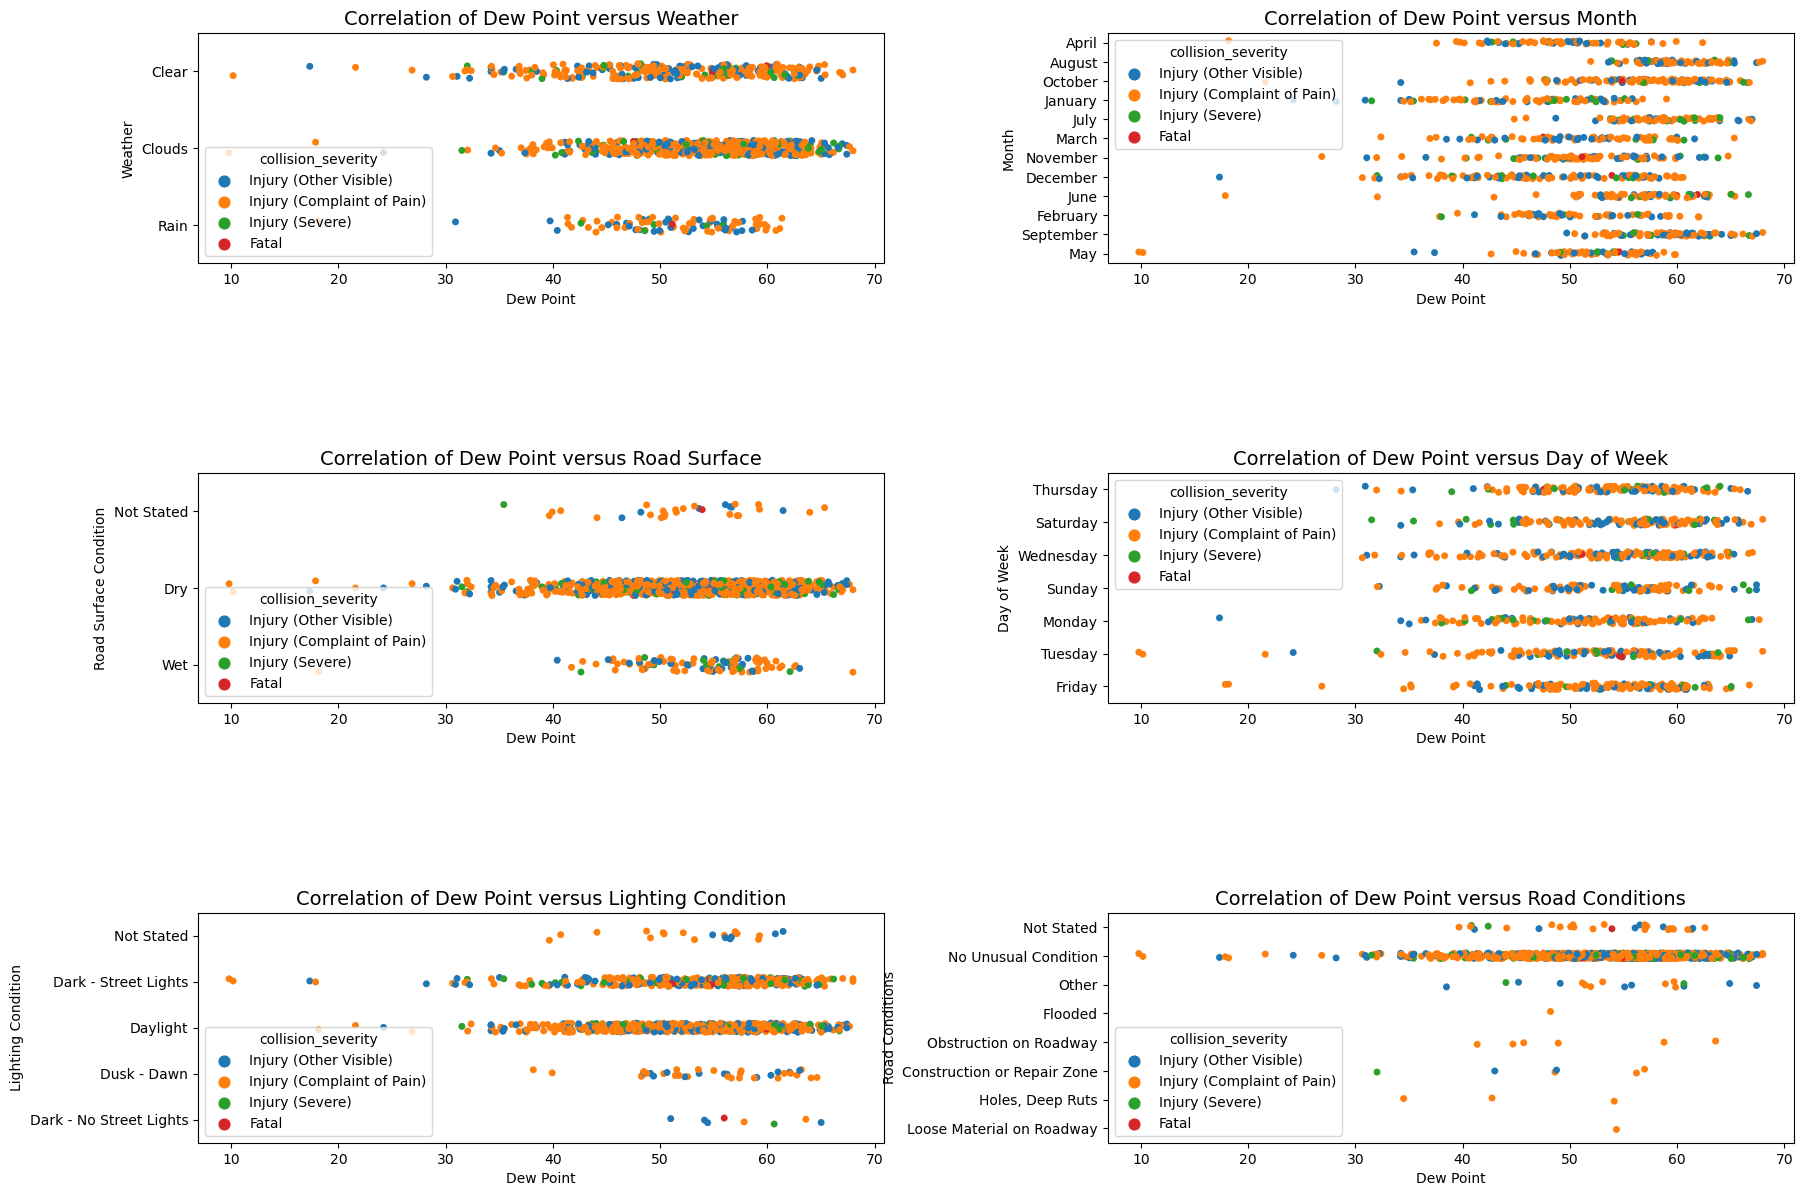

In [198]:
# Draw a categorical scatterplot to show each observation. stripplot is used to reduce overplotting
fig,ax = plt.subplots(3,2,figsize=(20,15))
fig.tight_layout(pad=13.0)

sns.stripplot(data=merged, x="dew_point", y="main", hue="collision_severity",ax=ax[0,0])
ax[0,0].set_ylabel('Weather')
ax[0,0].set_xlabel('Dew Point')
ax[0,0].set_title('Correlation of Dew Point versus Weather',fontsize=14)

sns.stripplot(data=merged, x="dew_point", y="road_surface", hue="collision_severity",ax=ax[1,0])
ax[1,0].set_ylabel('Road Surface Condition')
ax[1,0].set_xlabel('Dew Point')
ax[1,0].set_title('Correlation of Dew Point versus Road Surface',fontsize=14)

sns.stripplot(data=merged, x="dew_point", y="lighting", hue="collision_severity",ax=ax[2,0])
ax[2,0].set_ylabel('Lighting Condition')
ax[2,0].set_xlabel('Dew Point')
ax[2,0].set_title('Correlation of Dew Point versus Lighting Condition',fontsize=14)

sns.stripplot(data=merged, x="dew_point", y="month", hue="collision_severity", ax=ax[0,1])
ax[0,1].set_ylabel('Month')
ax[0,1].set_xlabel('Dew Point')
ax[0,1].set_title('Correlation of Dew Point versus Month',fontsize=14)

sns.stripplot(data=merged, x="dew_point", y="day_of_week", hue="collision_severity",ax=ax[1,1])
ax[1,1].set_ylabel('Day of Week')
ax[1,1].set_xlabel('Dew Point')
ax[1,1].set_title('Correlation of Dew Point versus Day of Week',fontsize=14)

sns.stripplot(data=merged, x="dew_point", y="road_cond_1", hue="collision_severity",ax=ax[2,1])
ax[2,1].set_ylabel('Road Conditions')
ax[2,1].set_xlabel('Dew Point')
ax[2,1].set_title('Correlation of Dew Point versus Road Conditions',fontsize=14)

plt.show()

# 3. Model Building

The predictors we will use are:
'humidity',
'tb_latitude',
'tb_longitude',
'dew_point',
'clouds',
'wind_speed',
'wind_deg',
'main_Clouds',
'main_Clear',
'road_surface_Dry',
'lighting_Daylight',
'lighting_Dark - Street Lights

And the outcome we want to predict is 'collision_severity_Injury (Complaint of Pain)' - moderate injury collisions

In [131]:
#### Step 0: import packages
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score,cross_val_predict

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression

import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV 
from xgboost import XGBClassifier 
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, ConfusionMatrixDisplay,confusion_matrix
from scipy.stats import randint



In [57]:
#### Create a crossvalidation object using the Kfold function. Use 5 splits.
cvdata = KFold(n_splits=5, random_state=0,shuffle=True)

In [145]:
log_dat.columns

Index(['tb_latitude', 'tb_longitude', 'collision_datetime', 'collision_date',
       'accident_year', 'month', 'day_of_week', 'primary_rd', 'weather_1',
       'collision_severity', 'road_surface', 'road_cond_1', 'lighting',
       'number_killed', 'number_injured', 'party1_type', 'total_involved',
       'main', 'description', 'temp', 'pressure', 'humidity', 'dew_point',
       'clouds', 'wind_speed', 'wind_deg', 'Hour', 'Accident_Count',
       'collision_severity_Injury (Other Visible)',
       'collision_severity_Injury (Complaint of Pain)',
       'collision_severity_Injury (Severe)', 'collision_severity_Fatal',
       'main_Clear', 'main_Clouds', 'main_Rain', 'road_surface_Dry',
       'road_surface_Not Stated', 'road_surface_Wet', 'party1_type_Bicyclist',
       'party1_type_Driver', 'party1_type_Other', 'party1_type_Parked Vehicle',
       'party1_type_Pedestrian', 'lighting_Dark - No Street Lights',
       'lighting_Dark - Street Lights', 'lighting_Daylight',
       'lighting_

## 3.1 Logistic Regression

In [217]:
X = log_dat[['humidity','tb_latitude', 'tb_longitude','dew_point','clouds','wind_speed','wind_deg','main_Clouds','main_Clear','road_surface_Dry','lighting_Daylight','lighting_Dark - Street Lights']]
y = log_dat["collision_severity_Injury (Complaint of Pain)"]

In [218]:
import statsmodels.api as sm

Xtrain = sm.add_constant(log_dat[['humidity','tb_latitude', 'tb_longitude','dew_point','clouds','wind_speed','wind_deg','main_Clouds','main_Clear','road_surface_Dry','lighting_Daylight','lighting_Dark - Street Lights']])
ytrain = log_dat[['collision_severity_Injury (Complaint of Pain)']].astype(int)
  
# building the model and fitting the data
log_reg = sm.Logit(ytrain, Xtrain).fit()

log_reg.summary()

Optimization terminated successfully.
         Current function value: 0.651690
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                                         Logit Regression Results                                        
=========================================================================================================
Dep. Variable:     collision_severity_Injury (Complaint of Pain)   No. Observations:                  995
Model:                                                     Logit   Df Residuals:                      982
Method:                                                      MLE   Df Model:                           12
Date:                                           Fri, 24 Feb 2023   Pseudo R-squ.:                0.005940
Time:                                                   09:35:24   Log-Likelihood:                -648.43
converged:                                                  True   LL-Null:                       -652.31
Covariance Type:                                       nonrobust   LLR p-value:                    0.8044
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                           108.9226    362.503      0.300      0.764    -601.570     819.415
humidity                          0.0031      0.005      0.563      0.574      -0.008       0.014
tb_latitude                      -1.9190      2.899     -0.662      0.508      -7.601       3.763
tb_longitude                      0.2989      2.612      0.114      0.909      -4.821       5.418
dew_point                        -0.0055      0.009     -0.583      0.560      -0.024       0.013
clouds                            0.0033      0.003      1.153      0.249      -0.002       0.009
wind_speed                        0.0612      0.038      1.593      0.111      -0.014       0.137
wind_deg                         -0.0005      0.001     -0.592      0.554      -0.002       0.001
main_Clouds                       0.4463      0.283      1.577      0.115      -0.108       1.001
main_Clear                        0.6144      0.378      1.626      0.104      -0.126       1.355
road_surface_Dry                 -0.0773      0.247     -0.313      0.754      -0.561       0.406
lighting_Daylight                 0.1888      0.275      0.686      0.492      -0.350       0.728
lighting_Dark - Street Lights    -0.0023      0.278     -0.008      0.994      -0.546       0.542
=================================================================================================
"""

In [219]:
# Create the logistic regression model
log_reg = LogisticRegression(penalty='none')

# Scale variables 
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [220]:
# Predict using cross validation
log_preds = cross_val_predict(log_reg, X, y, cv=cvdata)

In [221]:
# Evaluate the model performance using accuracy, precision, and F1 score 
accuracy = round(accuracy_score(y, log_preds),4) 

precision = round(precision_score(y, log_preds),4) 

f1 = round(f1_score(y, log_preds),4)

recall = round(recall_score(y, log_preds),4)

roc_auc = round(roc_auc_score(y, log_preds),4)

In [222]:
print("Accuracy:", accuracy) 
print("Precision:", precision)
print("Recall:", recall)
print("F1 score:", f1) 
print("AUC-ROC Score:", roc_auc)

Accuracy: 0.6352
Precision: 0.6366
Recall: 0.9937
F1 score: 0.7761
AUC-ROC Score: 0.501


XGBoost confusion matrix:
 [[  3 359]
 [  4 629]]


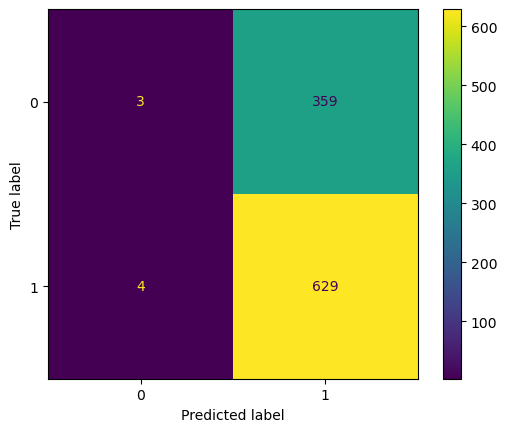

In [223]:
# Create confusion matrix visual

cm_xgb = confusion_matrix(y, log_preds) 

print("XGBoost confusion matrix:\n", cm_xgb) 

disp = ConfusionMatrixDisplay(confusion_matrix=cm_xgb)
disp.plot()

## 3.2 XGBoost

In [233]:
# Define the input and output variables
X = log_dat[['humidity','tb_latitude', 'tb_longitude','dew_point','clouds','wind_speed','wind_deg','main_Clouds','main_Clear','road_surface_Dry','lighting_Daylight','lighting_Dark - Street Lights']]
y = log_dat["collision_severity_Injury (Complaint of Pain)"]

In [234]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#using .ravel() to reshape the target variable into 1D array
y_train = y_train.values.ravel()

# Define the parameter grid for randomized search 

param_grid = { 
    'learning_rate': [0.01, 0.1, 0.5], 
    'max_depth': [3, 5, 7], 
    'n_estimators': [50, 100, 200], 
    'gamma': [0, 0.1, 0.5], 
    'subsample': [0.5, 0.8, 1], 
    'colsample_bytree': [0.5, 0.8, 1], 
    'reg_alpha': [0, 0.1, 0.5], 
    'reg_lambda': [1, 5, 10], 
} 

In [235]:
# Create an XGBoost classifier and perform randomized search 

xgb = XGBClassifier(random_state=42) 

random_search = RandomizedSearchCV(xgb, param_distributions=param_grid, n_iter=100, cv=cvdata, random_state=42) 

random_search.fit(X_train, y_train) 
# Print the best parameters found by randomized search 

print("Best parameters:", random_search.best_params_) 

Best parameters: {'subsample': 0.5, 'reg_lambda': 10, 'reg_alpha': 0, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.01, 'gamma': 0.5, 'colsample_bytree': 1}


In [236]:
# Predict the y variable on the test set using the trained XGBoost model 

xgb_preds = random_search.predict(X_test) 

# Evaluate the model performance using accuracy, precision, and F1 score 

accuracy = round(accuracy_score(y_test, xgb_preds),4) 

precision = round(precision_score(y_test, xgb_preds),4) 

f1 = round(f1_score(y_test, xgb_preds),4)

recall = round(recall_score(y_test, xgb_preds),4)

roc_auc = round(roc_auc_score(y_test, xgb_preds),4)

In [237]:
# Predict the trained y variable on the test set using the trained XGBoost model 

xgb_preds_1 = random_search.predict(X_train)

# Evaluate the model performance using accuracy, precision, and F1 score 

train_accuracy = round(accuracy_score(y_train, xgb_preds_1),4) 

train_precision = round(precision_score(y_train, xgb_preds_1),4) 

train_f1 = round(f1_score(y_train, xgb_preds_1),4)

train_recall = round(recall_score(y_train, xgb_preds_1),4)

train_roc_auc = round(roc_auc_score(y_train, xgb_preds_1),4)

In [238]:
# Evaluate training model performance
print("Train Accuracy:", train_accuracy) 
print("Train Precision:", train_precision) 
print("Train Recall:", train_recall)
print("Train F1 score:", train_f1)
print("Train AUC-ROC Score:", train_roc_auc)

Train Accuracy: 0.6583
Train Precision: 0.6512
Train Recall: 0.998
Train F1 score: 0.7882
Train AUC-ROC Score: 0.5302


In [239]:
# Evaluate test model performance
print("Test Accuracy:", accuracy) 
print("Test Precision:", precision)
print("Test Recall:", recall) 
print("Test F1 score:", f1) 
print("Test AUC-ROC Score:", roc_auc)

Test Accuracy: 0.6181
Test Precision: 0.6289
Test Recall: 0.9683
Test F1 score: 0.7625
Test AUC-ROC Score: 0.491


XGBoost confusion matrix:
 [[  1  72]
 [  4 122]]


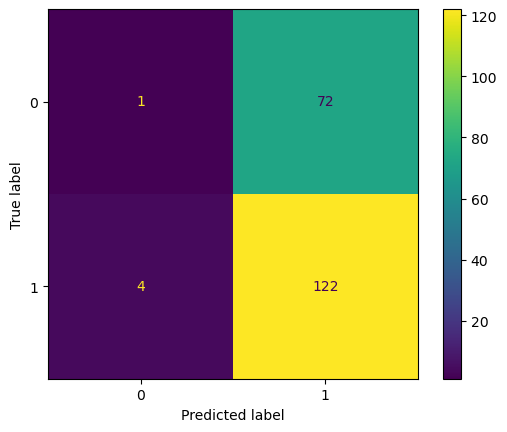

In [206]:
# Create confusion matrix visual

cm_xgb = confusion_matrix(y_test, xgb_preds) 

print("XGBoost confusion matrix:\n", cm_xgb) 

disp = ConfusionMatrixDisplay(confusion_matrix=cm_xgb)
disp.plot()

## 3.3 Random Forrest

In [224]:
# Define the input and output variables
X = log_dat[['humidity','tb_latitude', 'tb_longitude','dew_point','clouds','wind_speed','wind_deg','main_Clouds','main_Clear','road_surface_Dry','lighting_Daylight','lighting_Dark - Street Lights']]
y = log_dat["collision_severity_Injury (Complaint of Pain)"]

In [225]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define hyperparameters to tune
param_dist = {
    'n_estimators': randint(100, 1000),
    'max_depth': randint(1, 50),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt', 'log2', None]
}

In [226]:
# Instantiate a RandomForestClassifier
clf = RandomForestClassifier(random_state=42)

# Instantiate a RandomizedSearchCV object
random_search = RandomizedSearchCV(clf, param_distributions=param_dist, n_iter=50, cv=cvdata, random_state=42)

In [227]:
#using .ravel() to reshape the target variable into 1D array
y_train = y_train.values.ravel()

# Fit the model to the training data using randomized search
random_search.fit(X_train, y_train) 

# Get the best hyperparameters
best_params = random_search.best_params_

# Instantiate a RandomForestClassifier with the best hyperparameters
clf = RandomForestClassifier(**best_params, random_state=42)

# Fit the model to the training data
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=18, max_features='log2', min_samples_leaf=2,
                       min_samples_split=3, n_estimators=369, random_state=42)

In [228]:
# Predict y values on test data
rf_preds = clf.predict(X_test)

# Evaluate the model performance using accuracy, precision, and F1 score 

accuracy = round(accuracy_score(y_test, rf_preds),4) 

precision = round(precision_score(y_test, rf_preds),4) 

f1 = round(f1_score(y_test, rf_preds),4)

recall = round(recall_score(y_test, rf_preds),4)

roc_auc = round(roc_auc_score(y_test, rf_preds),4)

In [229]:
# Predict the y variable on the test set using the trained XGBoost model 

rf_preds_1 = random_search.predict(X_train)

# Evaluate the model performance using accuracy, precision, and F1 score 

train_accuracy = round(accuracy_score(y_train, rf_preds_1),4) 

train_precision = round(precision_score(y_train, rf_preds_1),4) 

train_f1 = round(f1_score(y_train, rf_preds_1),4)

train_recall = round(recall_score(y_train, rf_preds_1),4)

train_roc_auc = round(roc_auc_score(y_train, rf_preds_1),4)

In [230]:
# Evaluate training model performance
print("Train Accuracy:", train_accuracy) 
print("Train Precision:", train_precision) 
print("Train Recall:", train_recall)
print("Train F1 score:", train_f1)
print("Train AUC-ROC Score:", train_roc_auc)

Train Accuracy: 1.0
Train Precision: 1.0
Train Recall: 1.0
Train F1 score: 1.0
Train AUC-ROC Score: 1.0


In [231]:
# Evaluate test model performance
print("Test Accuracy:", accuracy) 
print("Test Precision:", precision) 
print("Test Recall:", recall)
print("Test F1 score:", f1) 
print("Test AUC-ROC Score:", roc_auc)

Test Accuracy: 0.603
Test Precision: 0.6328
Test Recall: 0.8889
Test F1 score: 0.7393
Test AUC-ROC Score: 0.4992


Random Forest confusion matrix:
 [[  8  65]
 [ 14 112]]


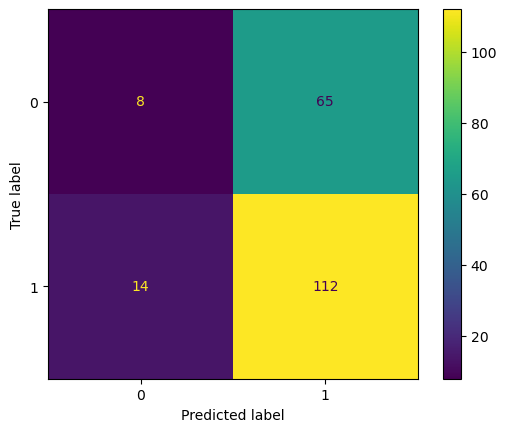

In [232]:
# Create confusion matrix visual
cm_rf = confusion_matrix(y_test, rf_preds)
print("Random Forest confusion matrix:\n", cm_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf)
disp.plot()

# 4. Conclusion 



| Scorings| Logistic Regression | XGBoost - train | XGBoost - test | Random Forest - train | Random Forest - test |
| -------- | -------- | -------- | -------- | -------- | -------- |
| Accuracy | 0.6352 | 0.6583 | 0.6181 | 1.0 | 0.603 |
| Precision | 0.6366 | 0.6512 | 0.6289 | 1.0 | 0.6328 |
| Recall | 0.9937 | 0.998 | 0.9683 | 1.0 | 0.8889 |
| F1 score | 0.7761 | 0.7882 | 0.7625 | 1.0 | 0.7393 |
| AUC-ROC Score| 0.5010 | 0.5302 | 0.4910 | 1.0 | 0.4992 |



The majority of accidents happened when the sky is clear or cloudy. The temperature does not appear to be a major factor in the likelihood of collisions that cause moderate injuries.  

We identified a set of predictors that will be utilized to make predictions. These include 'humidity', 'tb_latitude', 'tb_longitude', 'dew_point', 'clouds', 'wind_speed', 'wind_deg', 'main_Clouds', 'main_Clear', 'road_surface_Dry', 'lighting_Daylight', and 'lighting_Dark - Street Lights'.

The desired outcome that we want to predict is 'collision_severity_Injury (Complaint of Pain)', specifically moderate injury collisions.

Based on the provided scores, it is difficult to definitively say which machine learning model performs better. However, we can analyze the metrics and make some observations:

1. Accuracy: Logistic Regression has the highest accuracy score, followed by XGBoost and then Random Forest. However, accuracy can sometimes be misleading and should not be the only metric used to evaluate model performance.

2. Precision: All three models have similar precision scores, with Random Forest having a slightly higher score. Precision measures the proportion of true positives among all positive predictions, which is important in situations where false positives can have significant consequences.

3. F1 score: Logistic Regression has the highest F1 score, followed by XGBoost and then Random Forest. F1 score is a metric that balances precision and recall and is a useful metric when the class distribution is imbalanced.

4. AUC-ROC Score: All three models have very low AUC-ROC scores, indicating that they perform poorly in distinguishing between positive and negative cases. AUC-ROC is a metric that evaluates the overall performance of the model across all possible classification thresholds.

The models ảe overfitting, they have high performance on the training dataset but poorẻ performance on the testing dataset, resulting in a high accuracy, precision, recall, and F1 score on the training dataset, but a low score on the testing dataset.


In general, further analysis is required to determine the exact cause of the issue and how to address it. It might be helpful to fine-tune the hyperparameters, increase the sample size, or adjust the feature selection to improve the performance of the models. it may also be worthwhile to try out other models or collect more data and see if they perform better than the three models evaluated here.